In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




1.   prepare X, and Y
2.   seperate it into train and test set
3.   setup xgboost parameters
4.   fit data
5.   predict



In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from keras import backend as K
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from keras.utils import np_utils
import xgboost as xgb
import gc
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_colwidth',1000)

In [20]:
main_path = 'drive/MyDrive/Colab Notebooks/dsai_hw4/dataset'

orders_DF = pd.read_csv(os.path.join(main_path, 'orders.csv'))  
prior_order_DF = pd.read_csv(os.path.join(main_path, 'order_products__prior.csv')) 
train_order_DF = pd.read_csv(os.path.join(main_path, 'order_products__train.csv')) 
products_DF = pd.read_csv(os.path.join(main_path, 'products.csv'))

In [21]:
orders_prior = orders_DF.loc[np.where(orders_DF['eval_set'] == 'prior')]
orders_train = orders_DF.loc[np.where(orders_DF['eval_set'] == 'train')]
orders_test  = orders_DF.loc[np.where(orders_DF['eval_set'] == 'test')] 
print('Prior case:', len(orders_prior))
print('Train case:', len(orders_train))
print('Test case:', len(orders_test))

Prior case: 3214874
Train case: 131209
Test case: 75000


In [5]:
# in this cell we can prove that test_set is get the all the test's user of its eval_set=prior and evaL_set=test to become test_set
previous_order_of_test = []
order_of_test = []

# get all the previous orders of test_orders, and keep in previous_order_of_test list
for i in range(orders_DF['order_id'].count()):
  if orders_DF['eval_set'][i] == 'test':
    previous_order_id = orders_DF['order_id'][i-1]
    test_order_id = orders_DF['order_id'][i]
    previous_order_of_test.append([previous_order_id, orders_DF['user_id'][i-1]])
    order_of_test.append([test_order_id, orders_DF['user_id'][i]])
    
previous_order_of_test = np.array(previous_order_of_test)
order_of_test = np.array(order_of_test)
print(previous_order_of_test.shape)
print(order_of_test.shape)
previous_order_of_test = pd.DataFrame(previous_order_of_test, columns = ['order_id','user_id'])
order_of_test = pd.DataFrame(order_of_test, columns = ['order_id','user_id'])
print(previous_order_of_test.head(10))
print(order_of_test.head(10))

(75000, 2)
(75000, 2)
   order_id  user_id
0   1402502        3
1   2557754        4
2    998866        6
3   1468214       11
4    221248       12
5    487368       15
6   2000615       16
7     86918       19
8   2741696       20
9   2647850       22
   order_id  user_id
0   2774568        3
1    329954        4
2   1528013        6
3   1376945       11
4   1356845       12
5   2161313       15
6   1416320       16
7   1735923       19
8   1980631       20
9    139655       22


In [22]:
test_data = orders_DF.merge(previous_order_of_test, how='inner', on=['order_id','user_id'])
# print(test_data.shape)
test_data = test_data.merge(prior_order_DF, how='inner', on='order_id')
# print(test_data.shape)

test_data = test_data[['user_id','order_id','product_id','add_to_cart_order','order_number','eval_set','order_dow','order_hour_of_day','days_since_prior_order','reordered']]
test_data = test_data.sort_values(by=['user_id','order_id','product_id'])
# print(test_data.head(10))
test_data = test_data.set_index(['user_id','product_id'])
print(test_data.head(10))
print(test_data.shape)

                    order_id  ...  reordered
user_id product_id            ...           
3       18599        1402502  ...          1
        21903        1402502  ...          1
        23650        1402502  ...          1
        24810        1402502  ...          1
        39190        1402502  ...          1
        47766        1402502  ...          1
4       21573        2557754  ...          0
        25623        2557754  ...          0
        26576        2557754  ...          0
6       8424          998866  ...          0

[10 rows x 8 columns]
(780800, 8)


In [7]:
train_data = orders_DF.merge(train_order_DF, how='inner', on='order_id')
train_data = train_data[['user_id','order_id','product_id','add_to_cart_order','order_number','eval_set','order_dow','order_hour_of_day','days_since_prior_order','reordered']]
train_data = train_data.set_index(['user_id','product_id'])
print(train_data.head(10))
print(train_data.columns)
print(train_data.shape)


                    order_id  ...  reordered
user_id product_id            ...           
1       196          1187899  ...          1
        25133        1187899  ...          1
        38928        1187899  ...          1
        26405        1187899  ...          1
        39657        1187899  ...          1
        10258        1187899  ...          1
        13032        1187899  ...          1
        26088        1187899  ...          1
        27845        1187899  ...          0
        49235        1187899  ...          1

[10 rows x 8 columns]
Index(['order_id', 'add_to_cart_order', 'order_number', 'eval_set',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'reordered'],
      dtype='object')
(1384617, 8)


In [8]:
# print(train_data.isna().any())
# print(test_data.isna().any())

train_data = train_data.drop(['eval_set','order_id'], axis=1)


X = train_data[['add_to_cart_order','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
Y = train_data['reordered'].astype(np.int)
print(X)
print(Y)

                    add_to_cart_order  ...  days_since_prior_order
user_id product_id                     ...                        
1       196                         1  ...                    14.0
        25133                       2  ...                    14.0
        38928                       3  ...                    14.0
        26405                       4  ...                    14.0
        39657                       5  ...                    14.0
...                               ...  ...                     ...
206209  40603                       4  ...                    30.0
        15655                       5  ...                    30.0
        42606                       6  ...                    30.0
        37966                       7  ...                    30.0
        39216                       8  ...                    30.0

[1384617 rows x 5 columns]
user_id  product_id
1        196           1
         25133         1
         38928         1
      

In [9]:
x_train, x_validate, y_train, y_validate = train_test_split(X,Y , test_size = 0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)

(1107693, 5)
(1107693,)
(276924, 5)
(276924,)


In [23]:
test_data = test_data.drop(['eval_set','order_id'], axis=1)
x_test = test_data[['add_to_cart_order','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
y_test = test_data['reordered'].astype(np.int)

(1107693, 5)
(1107693,)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_boost_round=10, objective='binary:logistic',
              parameters={'colsample_bytree': '0.5', 'eval_metric': 'logloss',
                          'gpu_id': '0', 'max_depth': '5', 'subsample': '0.75',
                          'tree_method': 'gpu_hist'},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'num_boost_round': 10,
 'objective': 'binary:logistic',
 'parameters': {'colsample_bytree': '0.5',
  'eval_metric': 'logloss',
  'gpu_id': '0',
  'max_depth': '5',
  'subsample': '0.75',
  'tree_method': 'gpu_hist'},
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

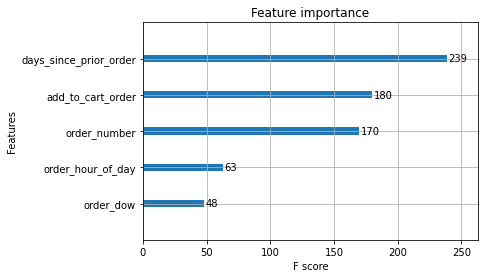

In [11]:
parameters = {'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.5',    # 0.4
              'subsample':'0.75',
              'gpu_id':'0',
              'tree_method':'gpu_hist'
             }

print(x_train.shape)
print(y_train.shape)
XGB = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)
model = XGB.fit(x_train, y_train)
print(model)
xgb.plot_importance(model)
model.get_xgb_params()


In [12]:
y_pred = model.predict(x_validate)
acc = accuracy_score(y_validate, y_pred)
fl_score = f1_score(y_validate, y_pred)

print('===Validate_set===')
print('Acc:',acc)
print('F1score:',fl_score)
print(y_pred.shape)

===Validate_set===
Acc: 0.661206684866606
F1score: 0.7427813175123648
(276924,)


In [13]:
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
fl_score = f1_score(y_test, y_pred)
print('===Test_set===')
print('Acc:',acc)
print('F1score:',fl_score)
print(y_pred.shape)

===Test_set===
Acc: 0.6626293545081967
F1score: 0.7355440682917721
(780800,)


In [61]:
# prepare submission's dataframe
submission_table = orders_DF.loc[orders_DF['eval_set'] == 'test', ['user_id','order_id']]
print(submission_table.head(10))

y_pred = pd.DataFrame(y_pred, columns=['reordered'])

test_data2 = test_data.drop(['reordered'], axis=1)
test_data2 = test_data2.reset_index()
test_data2['reordered'] = y_pred
print(test_data2.head(10))
# test_data2 = test_data2.set_index(['user_id','product_id'])


submission_table = submission_table.merge(test_data2, how='left', on='user_id')
print(submission_table)
submission_table = submission_table[['order_id','product_id','reordered']]
print(submission_table)

output_result = dict()
for row in submission_table.itertuples():
  if row.reordered == 1:
    try:
      output_result[row.order_id] += ' ' + str(row.product_id)
    except:
      output_result[row.order_id] = str(row.product_id)

for order in submission_table.order_id:
  if order not in output_result:
    output_result[order] = 'None'

submission = pd.DataFrame.from_dict(output_result, orient='index')
submission.reset_index(inplace=True)
submission.columns = ['order_id','products']
# print(submission.head(50))
submission
submission.to_csv('submission.csv',index=False)

     user_id  order_id
38         3   2774568
44         4    329954
53         6   1528013
96        11   1376945
102       12   1356845
152       15   2161313
159       16   1416320
217       19   1735923
222       20   1980631
272       22    139655
   user_id  product_id  ...  days_since_prior_order  reordered
0        3       18599  ...                    15.0          1
1        3       21903  ...                    15.0          1
2        3       23650  ...                    15.0          1
3        3       24810  ...                    15.0          1
4        3       39190  ...                    15.0          1
5        3       47766  ...                    15.0          1
6        4       21573  ...                     0.0          1
7        4       25623  ...                     0.0          1
8        4       26576  ...                     0.0          1
9        6        8424  ...                    12.0          1

[10 rows x 8 columns]
        user_id  order_id  ... 